In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import numpy as np

In [2]:
# import R to be used in python 
# sorry R people that may be reading this code 
import rpy2
%load_ext rpy2.ipython

In [3]:
# set white seaborn plotting style 
sns.set(context='talk', style='white', rc={'figure.facecolor':'white'}, font_scale=1)
sns.set_style('ticks')

In [4]:
os.chdir("/Users/christacaggiano/Documents/UCLA_year3/celfie/")

In [5]:
tissue_proportions = pd.read_csv("EM/sample_output/1_tissue_proportions.txt", delimiter="\t")

In [6]:
tissue_proportions.rename(columns={"Unnamed: 0": "samples"}, inplace=True)

In [7]:
tissue_proportions = tissue_proportions.melt("samples",  var_name="tissue", value_name="estimate")

In [8]:
tissue_proportions["status"] = np.where(tissue_proportions["samples"].str.contains("als"), "ALS", "control") 

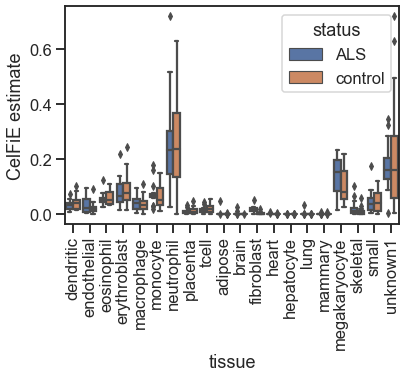

In [9]:
sns.boxplot(x="tissue", y="estimate", hue="status", data=tissue_proportions)
plt.xticks(rotation=90)
plt.ylabel("CelFiE estimate")
plt.xlabel("tissue")
plt.show()

In [10]:
tissue_proportions.to_csv("celfie_demo/tissue_proportions.csv", index=False)

In [12]:
tissue_proportions

,samples,tissue,estimate,status
0,als1,dendritic,0.018167,ALS
1,als10,dendritic,0.035640,ALS
2,als11,dendritic,0.039558,ALS
3,als12,dendritic,0.073900,ALS
4,als13,dendritic,0.027355,ALS
5,als14,dendritic,0.035636,ALS
6,als15,dendritic,0.040105,ALS
7,als16,dendritic,0.013929,ALS
8,ctrl17,dendritic,0.031348,control
9,ctrl18,dendritic,0.015965,control


In [11]:
%%R 
# R code to calculate the p-value between the concentration differences 

df = read.csv("celfie_demo/tissue_proportions.csv")  # re-read in the dataframe for this R code 
df$status <- as.character(df$status)
df$status[df$status == "ALS"] <- 1
df$status[df$status == "control"] <- 0
df$status <- as.numeric(df$status)

skeletal = subset(df, df$tissue=="skeletal")

summary(glm(status ~ estimate, data = skeletal))



Call:
glm(formula = status ~ estimate, data = skeletal)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7242  -0.4461  -0.1814   0.5178   0.5792  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.4194     0.1079   3.887  0.00052 ***
estimate      5.1178     3.8933   1.315  0.19863    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2521431)

    Null deviance: 8.0000  on 31  degrees of freedom
Residual deviance: 7.5643  on 30  degrees of freedom
AIC: 50.659

Number of Fisher Scoring iterations: 2

